In [2]:
import sys
sys.path.append("../")

import torch
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load the config file
with open('../data/data_config.json', 'r') as file:
    config = json.load(file)

# d = 3

In [3]:
torch.manual_seed(42)

dataset = 'sbm3_unbalanced_positive_v2'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])
num_nodes = np.sum(n)

nodes = [num_nodes*2*i for i in range(1,11)]
n = [[120*2*i, 80*2*i, 40*2*i] for i in range(1,11)]

In [5]:
with open(f'../training/results/svd_performance_{dataset}.pkl', 'rb') as f:
    svd_exec_time = pickle.load(f)

with open(f'../training/results/coord_gd_performance_{dataset}.pkl', 'rb') as f:
    cgd_exec_time = pickle.load(f)

with open(f'../training/results/lase_full_performance_{dataset}.pkl', 'rb') as f:
    lase_full_exec_time = pickle.load(f)
    
with open(f'../training/results/lase_ER05_performance_{dataset}.pkl', 'rb') as f:
    lase_ER05_exec_time = pickle.load(f)
        
with open(f'../training/results/lase_WS03_performance_{dataset}.pkl', 'rb') as f:
    lase_WS03_exec_time = pickle.load(f)

with open(f'../training/results/lase_BB03_performance_{dataset}.pkl', 'rb') as f:
    lase_BB03_exec_time = pickle.load(f) 

## Performance comparison

/tmp/ipykernel_170539/607300572.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  crest_cmap = cm.get_cmap('Accent_r')
/tmp/ipykernel_170539/607300572.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(nodes, lase_full_exec_time[:,0], c=colors[5], label='LASE Full Attention')
/tmp/ipykernel_170539/607300572.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyw

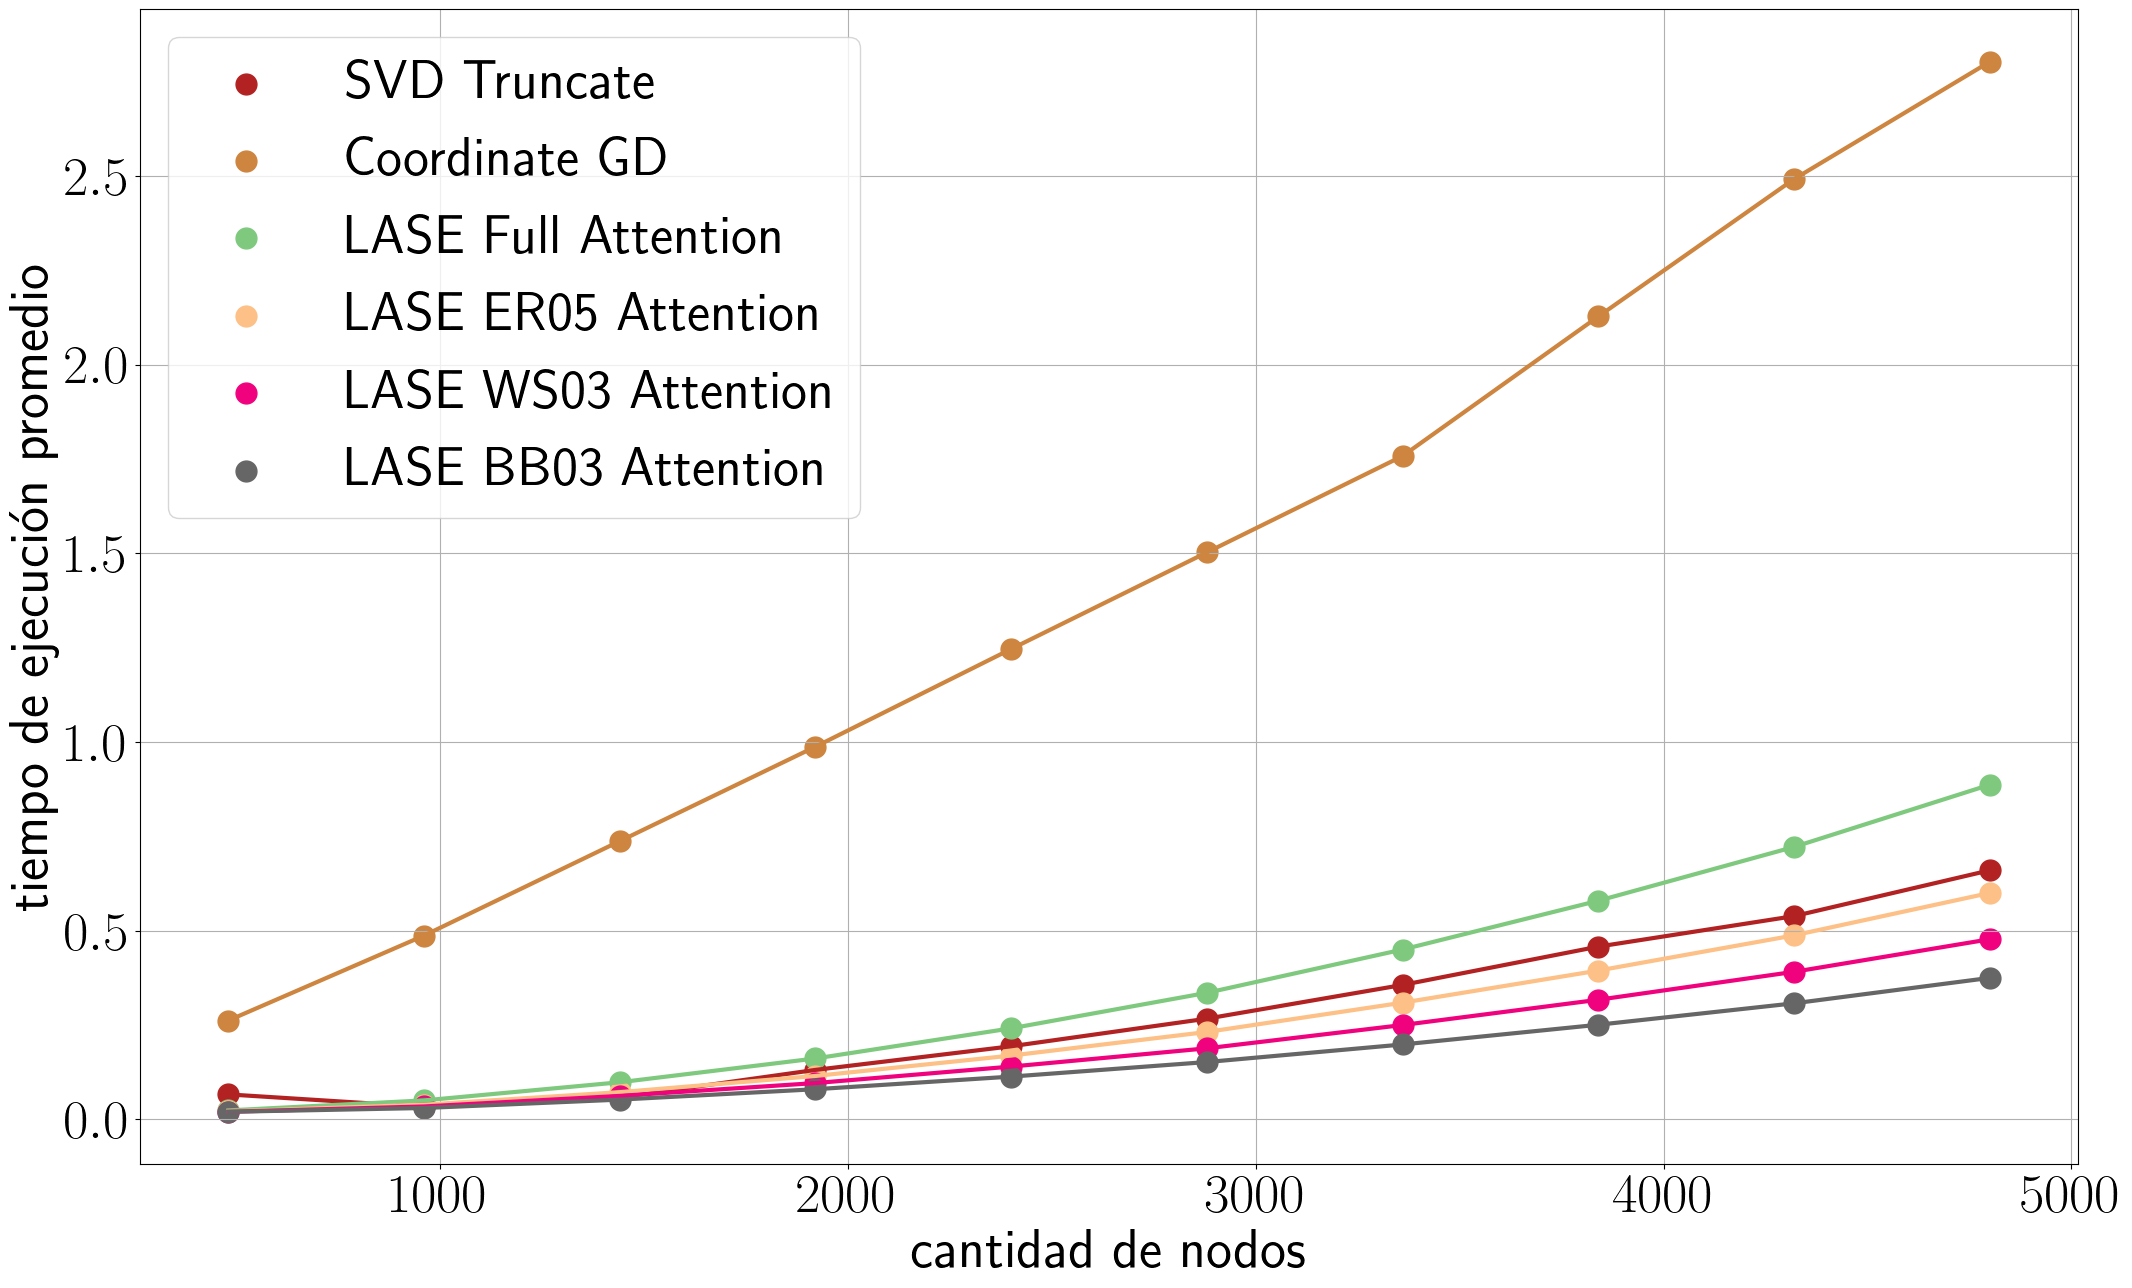

In [7]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 40
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True


crest_cmap = cm.get_cmap('Accent_r')

# Generate colors from the colormap
colors = [crest_cmap(i) for i in np.linspace(0, 2, 12)]  # Generate 8 colors from the crest colormap

plt.figure(figsize =(25,15))
# Adjust each plot to use a color from the generated list
plt.scatter(nodes, svd_exec_time[:,0], c='firebrick', label='SVD Truncate')
plt.plot(nodes, svd_exec_time[:,0], c='firebrick')
plt.scatter(nodes, cgd_exec_time[:,0], c='peru', label='Coordinate GD')
plt.plot(nodes, cgd_exec_time[:,0], c='peru')
plt.scatter(nodes, lase_full_exec_time[:,0], c=colors[5], label='LASE Full Attention')
plt.plot(nodes, lase_full_exec_time[:,0], c=colors[5])
plt.scatter(nodes, lase_ER05_exec_time[:,0], c=colors[4], label='LASE ER05 Attention')
plt.plot(nodes, lase_ER05_exec_time[:,0], c=colors[4])
plt.scatter(nodes, lase_WS03_exec_time[:,0], c=colors[2], label='LASE WS03 Attention')
plt.plot(nodes, lase_WS03_exec_time[:,0], c=colors[2])
plt.scatter(nodes, lase_BB03_exec_time[:,0], c=colors[0], label='LASE BB03 Attention')
plt.plot(nodes, lase_BB03_exec_time[:,0], c=colors[0])
plt.xlabel('cantidad de nodos')
plt.ylabel('tiempo de ejecución promedio')
plt.legend()
plt.show()

In [8]:
print(f'{nodes[0]}  _ {svd_exec_time[0,0]:.2f} _ {svd_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {svd_exec_time[2,0]:.2f} _ {svd_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {svd_exec_time[4,0]:.2f} _ {svd_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {svd_exec_time[6,0]:.2f} _ {svd_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {svd_exec_time[9,0]:.2f} _ {svd_exec_time[9,1]:.2f} ')

480  _ 0.07 _ 0.01 
1440 _ 0.06 _ 0.00 
2400 _ 0.19 _ 0.01 
3360 _ 0.36 _ 0.01 
4800 _ 0.66 _ 0.01 


In [9]:
print(f'{nodes[0]}  _ {cgd_exec_time[0,0]:.2f} _ {cgd_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {cgd_exec_time[2,0]:.2f} _ {cgd_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {cgd_exec_time[4,0]:.2f} _ {cgd_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {cgd_exec_time[6,0]:.2f} _ {cgd_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {cgd_exec_time[9,0]:.2f} _ {cgd_exec_time[9,1]:.2f} ')

480  _ 0.26 _ 0.02 
1440 _ 0.74 _ 0.00 
2400 _ 1.25 _ 0.00 
3360 _ 1.76 _ 0.00 
4800 _ 2.80 _ 0.00 


In [10]:
print(f'{nodes[0]}  _ {lase_full_exec_time[0,0]:.2f} _ {lase_full_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_full_exec_time[2,0]:.2f} _ {lase_full_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_full_exec_time[4,0]:.2f} _ {lase_full_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_full_exec_time[6,0]:.2f} _ {lase_full_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_full_exec_time[9,0]:.2f} _ {lase_full_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.00 
1440 _ 0.10 _ 0.00 
2400 _ 0.24 _ 0.00 
3360 _ 0.45 _ 0.00 
4800 _ 0.89 _ 0.00 


In [11]:
print(f'{nodes[0]}  _ {lase_ER05_exec_time[0,0]:.2f} _ {lase_ER05_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_ER05_exec_time[2,0]:.2f} _ {lase_ER05_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_ER05_exec_time[4,0]:.2f} _ {lase_ER05_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_ER05_exec_time[6,0]:.2f} _ {lase_ER05_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_ER05_exec_time[9,0]:.2f} _ {lase_ER05_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.00 
1440 _ 0.07 _ 0.00 
2400 _ 0.17 _ 0.00 
3360 _ 0.31 _ 0.00 
4800 _ 0.60 _ 0.00 


In [12]:
print(f'{nodes[0]}  _ {lase_WS03_exec_time[0,0]:.2f} _ {lase_WS03_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_WS03_exec_time[2,0]:.2f} _ {lase_WS03_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_WS03_exec_time[4,0]:.2f} _ {lase_WS03_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_WS03_exec_time[6,0]:.2f} _ {lase_WS03_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_WS03_exec_time[9,0]:.2f} _ {lase_WS03_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.01 
1440 _ 0.06 _ 0.00 
2400 _ 0.14 _ 0.00 
3360 _ 0.25 _ 0.00 
4800 _ 0.48 _ 0.00 


In [13]:
print(f'{nodes[0]}  _ {lase_BB03_exec_time[0,0]:.2f} _ {lase_BB03_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_BB03_exec_time[2,0]:.2f} _ {lase_BB03_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_BB03_exec_time[4,0]:.2f} _ {lase_BB03_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_BB03_exec_time[6,0]:.2f} _ {lase_BB03_exec_time[6,1]:.2f} ')
print(f'{nodes[9]} _ {lase_BB03_exec_time[9,0]:.2f} _ {lase_BB03_exec_time[9,1]:.2f} ')

480  _ 0.02 _ 0.01 
1440 _ 0.05 _ 0.00 
2400 _ 0.11 _ 0.00 
3360 _ 0.20 _ 0.00 
4800 _ 0.37 _ 0.00 


In [14]:
lase_full_exec_time[9,0]/lase_BB03_exec_time[9,0]

2.3648283365565232

In [16]:
cgd_exec_time[9,0]/lase_BB03_exec_time[9,0]

7.47402257555686

In [17]:
svd_exec_time[9,0] / lase_BB03_exec_time[9,0]

1.7602439195425443

# d = 10

In [18]:
torch.manual_seed(42)

dataset = 'sbm10_unbalanced_positive'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])
num_nodes = np.sum(n)

nodes = [num_nodes*i for i in range(1,8)]
nodes.append(4125)
n_array = [[80*i, 50*i, 80*i, 40*i, 50*i, 60*i, 50*i, 50*i, 40*i, 50*i] for i in range(1,8)]
n_array.append([600, 375, 600, 300, 375, 450, 375, 375, 300, 375])

In [19]:
with open(f'../training/results/svd_performance_{dataset}.pkl', 'rb') as f:
    svd_exec_time = pickle.load(f)

with open(f'../training/results/coord_gd_performance_{dataset}.pkl', 'rb') as f:
    cgd_exec_time = pickle.load(f)

with open(f'../training/results/lase_full_performance_{dataset}.pkl', 'rb') as f:
    lase_full_exec_time = pickle.load(f)
    
with open(f'../training/results/lase_ER05_performance_{dataset}.pkl', 'rb') as f:
    lase_ER05_exec_time = pickle.load(f)
        
with open(f'../training/results/lase_WS03_performance_{dataset}.pkl', 'rb') as f:
    lase_WS03_exec_time = pickle.load(f)

with open(f'../training/results/lase_BB03_performance_{dataset}.pkl', 'rb') as f:
    lase_BB03_exec_time = pickle.load(f) 

/tmp/ipykernel_170539/506352419.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  crest_cmap = cm.get_cmap('Accent_r')
/tmp/ipykernel_170539/506352419.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(nodes, lase_full_exec_time[:,0], c=colors[5], label='LASE Full Attention')
/tmp/ipykernel_170539/506352419.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyw

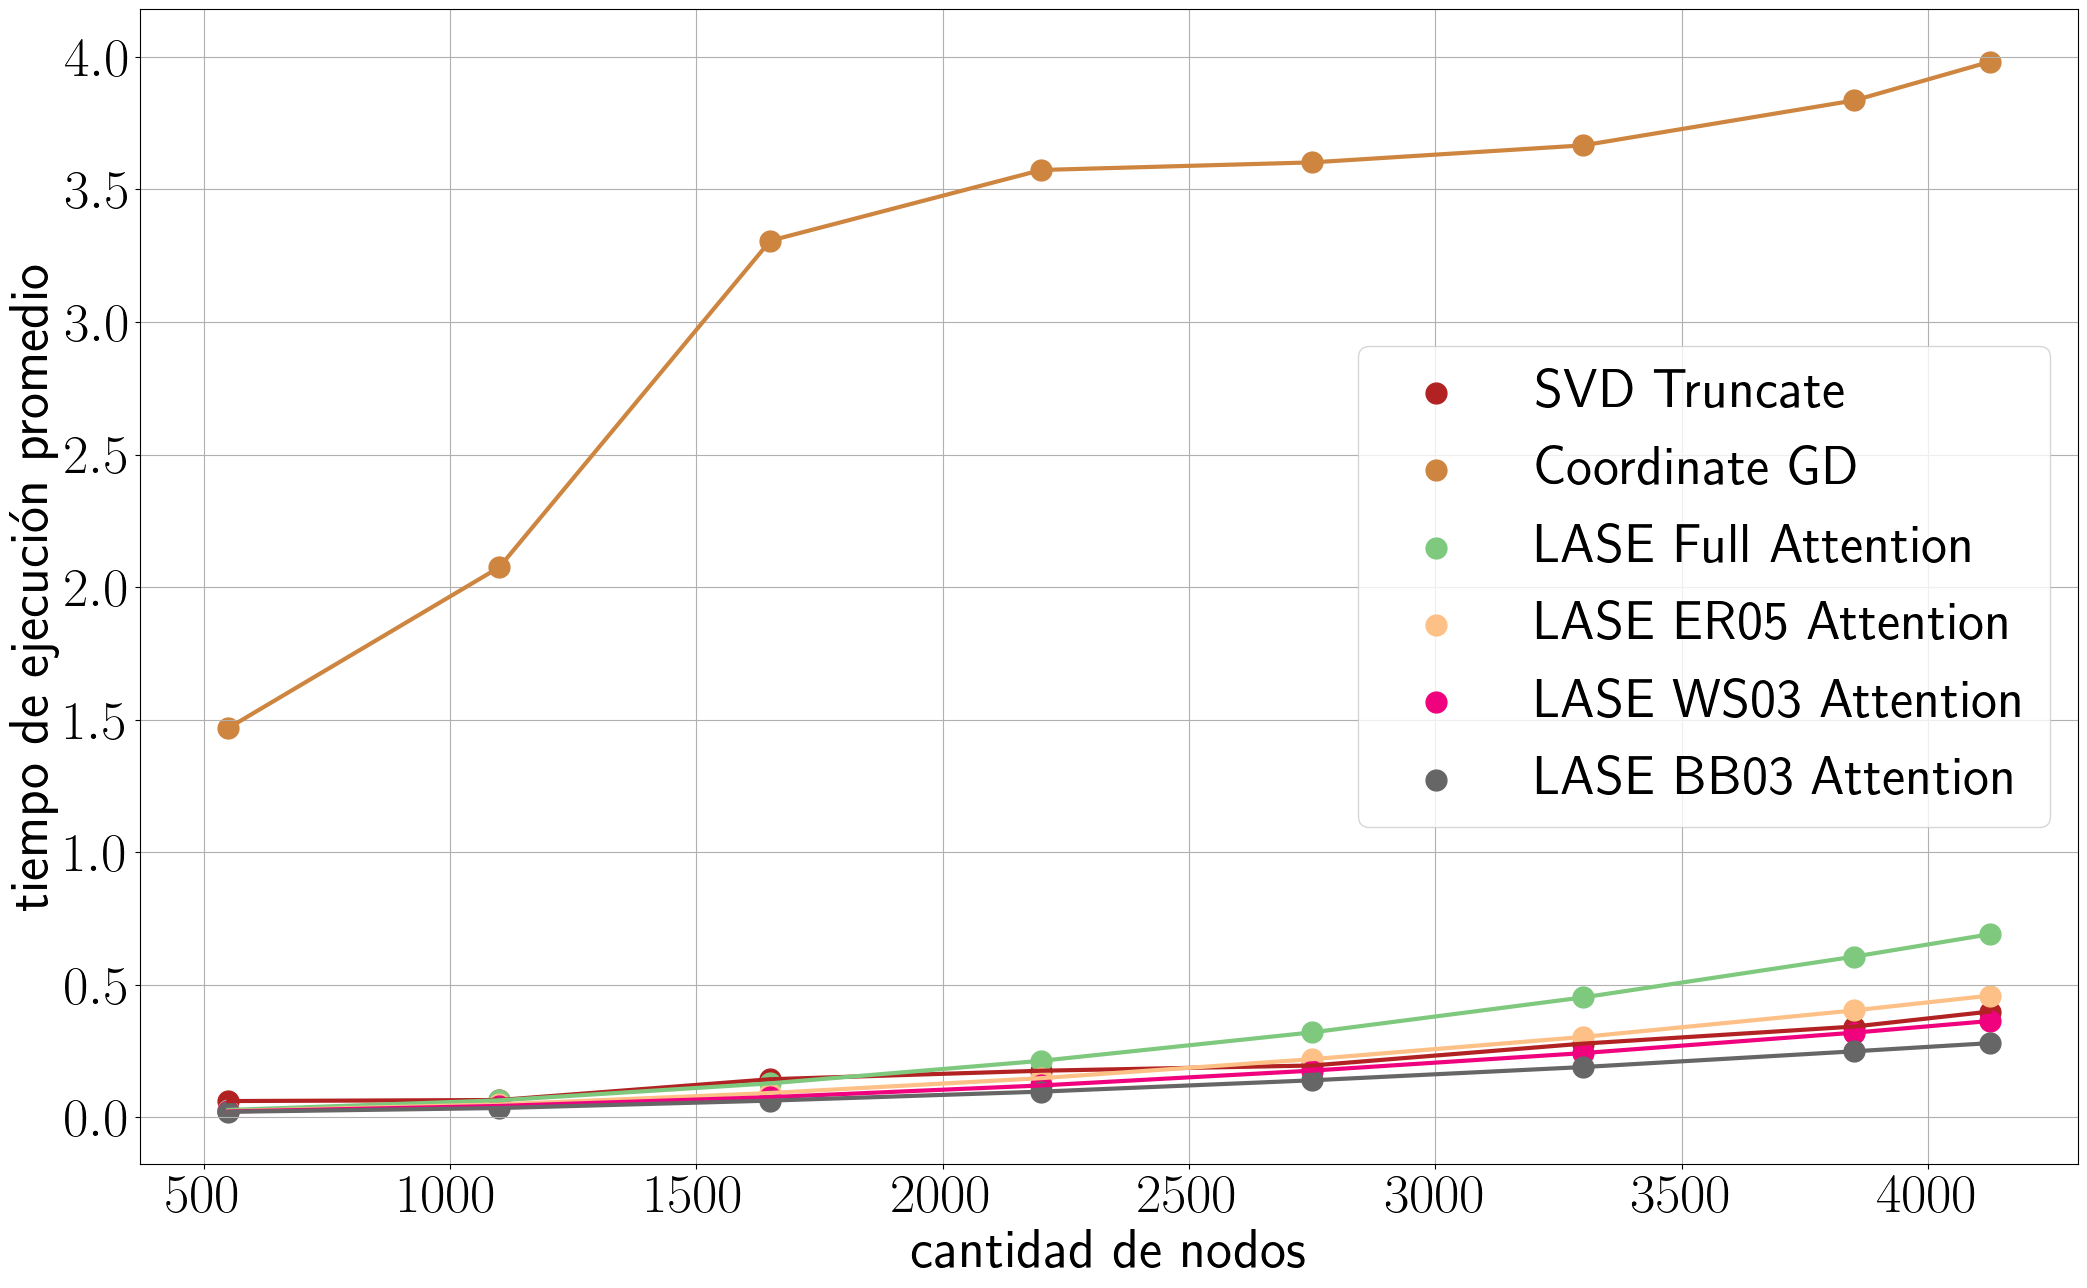

In [20]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 40
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = True

crest_cmap = cm.get_cmap('Accent_r')

# Generate colors from the colormap
colors = [crest_cmap(i) for i in np.linspace(0, 2, 12)]  # Generate 8 colors from the crest colormap

plt.figure(figsize =(25,15))
# Adjust each plot to use a color from the generated list
plt.scatter(nodes, svd_exec_time[:,0], c='firebrick', label='SVD Truncate')
plt.plot(nodes, svd_exec_time[:,0], c='firebrick')
plt.scatter(nodes, cgd_exec_time[:,0], c='peru', label='Coordinate GD')
plt.plot(nodes, cgd_exec_time[:,0], c='peru')
plt.scatter(nodes, lase_full_exec_time[:,0], c=colors[5], label='LASE Full Attention')
plt.plot(nodes, lase_full_exec_time[:,0], c=colors[5])
plt.scatter(nodes, lase_ER05_exec_time[:,0], c=colors[4], label='LASE ER05 Attention')
plt.plot(nodes, lase_ER05_exec_time[:,0], c=colors[4])
plt.scatter(nodes, lase_WS03_exec_time[:,0], c=colors[2], label='LASE WS03 Attention')
plt.plot(nodes, lase_WS03_exec_time[:,0], c=colors[2])
plt.scatter(nodes, lase_BB03_exec_time[:,0], c=colors[0], label='LASE BB03 Attention')
plt.plot(nodes, lase_BB03_exec_time[:,0], c=colors[0])
plt.xlabel('cantidad de nodos')
plt.ylabel('tiempo de ejecución promedio')
plt.legend()
plt.show()


In [21]:
print(f'{nodes[0]}  _ {svd_exec_time[0,0]:.2f} _ {svd_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {svd_exec_time[2,0]:.2f} _ {svd_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {svd_exec_time[4,0]:.2f} _ {svd_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {svd_exec_time[6,0]:.2f} _ {svd_exec_time[6,1]:.2f} ')
print(f'{nodes[7]} _ {svd_exec_time[7,0]:.2f} _ {svd_exec_time[7,1]:.2f} ')

550  _ 0.06 _ 0.01 
1650 _ 0.14 _ 0.01 
2750 _ 0.20 _ 0.01 
3850 _ 0.34 _ 0.00 
4125 _ 0.40 _ 0.01 


In [22]:
print(f'{nodes[0]}  _ {cgd_exec_time[0,0]:.2f} _ {cgd_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {cgd_exec_time[2,0]:.2f} _ {cgd_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {cgd_exec_time[4,0]:.2f} _ {cgd_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {cgd_exec_time[6,0]:.2f} _ {cgd_exec_time[6,1]:.2f} ')
print(f'{nodes[7]} _ {cgd_exec_time[7,0]:.2f} _ {cgd_exec_time[7,1]:.2f} ')

550  _ 1.47 _ 0.04 
1650 _ 3.31 _ 0.08 
2750 _ 3.60 _ 0.07 
3850 _ 3.84 _ 0.08 
4125 _ 3.98 _ 0.09 


In [23]:
print(f'{nodes[0]}  _ {lase_full_exec_time[0,0]:.2f} _ {lase_full_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_full_exec_time[2,0]:.2f} _ {lase_full_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_full_exec_time[4,0]:.2f} _ {lase_full_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_full_exec_time[6,0]:.2f} _ {lase_full_exec_time[6,1]:.2f} ')
print(f'{nodes[7]} _ {lase_full_exec_time[7,0]:.2f} _ {lase_full_exec_time[7,1]:.2f} ')

550  _ 0.03 _ 0.00 
1650 _ 0.13 _ 0.00 
2750 _ 0.32 _ 0.00 
3850 _ 0.61 _ 0.00 
4125 _ 0.69 _ 0.00 


In [24]:
print(f'{nodes[0]}  _ {lase_ER05_exec_time[0,0]:.2f} _ {lase_ER05_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_ER05_exec_time[2,0]:.2f} _ {lase_ER05_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_ER05_exec_time[4,0]:.2f} _ {lase_ER05_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_ER05_exec_time[6,0]:.2f} _ {lase_ER05_exec_time[6,1]:.2f} ')
print(f'{nodes[7]} _ {lase_ER05_exec_time[7,0]:.2f} _ {lase_ER05_exec_time[7,1]:.2f} ')

550  _ 0.02 _ 0.00 
1650 _ 0.09 _ 0.00 
2750 _ 0.22 _ 0.00 
3850 _ 0.40 _ 0.00 
4125 _ 0.46 _ 0.00 


In [25]:
print(f'{nodes[0]}  _ {lase_WS03_exec_time[0,0]:.2f} _ {lase_WS03_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_WS03_exec_time[2,0]:.2f} _ {lase_WS03_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_WS03_exec_time[4,0]:.2f} _ {lase_WS03_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_WS03_exec_time[6,0]:.2f} _ {lase_WS03_exec_time[6,1]:.2f} ')
print(f'{nodes[7]} _ {lase_WS03_exec_time[7,0]:.2f} _ {lase_WS03_exec_time[7,1]:.2f} ')

550  _ 0.02 _ 0.00 
1650 _ 0.08 _ 0.00 
2750 _ 0.18 _ 0.00 
3850 _ 0.32 _ 0.00 
4125 _ 0.36 _ 0.00 


In [26]:
print(f'{nodes[0]}  _ {lase_BB03_exec_time[0,0]:.2f} _ {lase_BB03_exec_time[0,1]:.2f} ')
print(f'{nodes[2]} _ {lase_BB03_exec_time[2,0]:.2f} _ {lase_BB03_exec_time[2,1]:.2f} ')
print(f'{nodes[4]} _ {lase_BB03_exec_time[4,0]:.2f} _ {lase_BB03_exec_time[4,1]:.2f} ')
print(f'{nodes[6]} _ {lase_BB03_exec_time[6,0]:.2f} _ {lase_BB03_exec_time[6,1]:.2f} ')
print(f'{nodes[7]} _ {lase_BB03_exec_time[7,0]:.2f} _ {lase_BB03_exec_time[7,1]:.2f} ')

550  _ 0.02 _ 0.00 
1650 _ 0.06 _ 0.00 
2750 _ 0.14 _ 0.00 
3850 _ 0.25 _ 0.00 
4125 _ 0.28 _ 0.00 


In [27]:
# LASE full vs Sparse LASE
1-lase_BB03_exec_time[7,0]/lase_full_exec_time[7,0]

0.5947288914733055

In [28]:
# CGD vs Sparse LASE
cgd_exec_time[7,0]/lase_BB03_exec_time[7,0]

14.223756530323751

In [29]:
# SVD vs Sparse LASE
svd_exec_time[7,0]/lase_BB03_exec_time[7,0]

1.4253856567177758